# Emotion-Semantic Mapping through Wikipedia Article Transitions

This notebook investigates the interplay between semantic shifts and emotional fluctuations as users navigate through Wikipedia articles. The goal is to understand how changes in content affect emotional responses during reading. Our approach begins by calculating semantic distances between consecutive articles using various text embeddings and distance measures, followed by clustering to identify the optimal metric for minimal bias. Next, we employ an emotion prediction model to assign 26 types of emotion scores to each navigation step, adjusting scores to account for reading behavior, such as increased attention on hyperlinks. Finally, we analyze correlations between semantic distance and emotion scores, exploring whether significant semantic shifts provoke specific emotional responses. This study aims to uncover patterns in how users emotionally respond to content transitions, providing insights into human cognitive and affective processing during online navigation.

In [1]:
# Suppress warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Semantic analysis scripts
from src.semantic.semantic_utils import (
	load_embedding_data,
	run_all_clustering,
	get_primary_category,
	evaluate_embeddings,
	process_path_data,
	
)

from src.semantic.semantic_visualization import (
	plot_clustering_distribution,
	analyze_semantic_distances,
)

from src.semantic.semantic_paper_utils import (
	process_wikispeedia_data,
)

from src.semantic.semantic_paper_visualization import (
	plot_semantic_network,
	visualize_distance_graph,
)
# Emotion analysis scripts
from src.emotion.emotion_visualization import (
  plot_link_frequencies,
	show_paths_lengths,
	plot_paths_with_random_samples,
	analyze_correlation
)
from src.emotion.emotion_utils import (
  extract_sentences, 
	generate_link_freq_dict,
	extract_path_data,
	calculate_emotion_jump_rates,
)
from src.emotion.emotion_scores import (
	calculate_weighted_emotion_for_single_path,
)
# Correlation scripts
from src.correlation.correlation_utils import (
	calculate_rowwise_correlation,
	mean_correlation,
)

[nltk_data] Downloading package punkt to /Users/fht/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fht/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/fht/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1. Explore Different Measures of Semantic Distance

### 1.1. Selecting Best Measure of Semantic Distance through traditional approaches

In this section, we represent the semantic distances between concepts using traditional computational methods and evaluate the reasonableness of the results.

We have clustered three types of embeddings that had been reduced in dimensionality using PCA (details of the PCA process can be found in clean_data_new.ipynb). For distance calculations, we employed both cosine distance and Euclidean distance, using K-Medoids as the clustering method. After evaluating the clustering results, we selected the best-performing distance calculation method as the semantic distance measure. Finally, we computed the semantic distances between consecutive concepts along each path.

#### 1.1.1. Text Embedding

In [2]:
# Example usage:
category_file = 'data/original_dataset/wikispeedia_paths-and-graph/categories.tsv'
MiniLM_file = 'data/semantic/pca_MiniLM_dimensions.pkl'
mpnet_file = 'data/semantic/pca_mpnet_dimensions.pkl'

MiniLM_embedding, MiniLM_values = load_embedding_data(category_file, MiniLM_file)
mpnet_embedding, mpnet_values = load_embedding_data(category_file, mpnet_file)

#### 1.1.2. Semantic Measure Evaluation: Clustering on Embeddings

In [3]:
MiniLM_clustering = run_all_clustering(MiniLM_file, category_file)
mpnet_clustering = run_all_clustering(mpnet_file, category_file)


Loaded 4604 concepts and corresponding embeddings from data/semantic/pca_MiniLM_dimensions.pkl.
15 categories found in wikispeedia.
Calculated 15 clusters based on data/original_dataset/wikispeedia_paths-and-graph/categories.tsv.


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Perform ['K-Medoids_Manhattan', 'K-Medoids_Cosine'] clustering algorithms successfully!
Loaded 4604 concepts and corresponding embeddings from data/semantic/pca_mpnet_dimensions.pkl.
15 categories found in wikispeedia.
Calculated 15 clusters based on data/original_dataset/wikispeedia_paths-and-graph/categories.tsv.


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

Perform ['K-Medoids_Manhattan', 'K-Medoids_Cosine'] clustering algorithms successfully!


the clustering results is stored as follows:

MiniLM_clustering
- K-Medoids Manhattan: Embeddings (DataFrame)
- K-Medoids Cosine: Embeddings (DataFrame)

In [4]:
# A sample of clustering results
MiniLM_clustering['K-Medoids_Manhattan'].head(5)

,concept,clustering
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
1,%C3%85land,0
2,%C3%89douard_Manet,1
3,%C3%89ire,6
4,%C3%93engus_I_of_the_Picts,0


#### 1.1.3. Category-Cluster Mapping and Evaluation

- This method calculates the Inter-Cluster Distance, Intra-Cluster Distance, Purity and Entropy for the Category-Cluster Mapping.
- First, the cluster-category mapping is sorted in descending order based on their mapping counts and then uniquely matched (each cluster corresponds to only one category, and each category corresponds to only one cluster).
- **Inter-Cluster** Distance measures the average distance between the centers of different clusters; higher values are better as they signify greater separation and distinctness between clusters.
- **Intra-Cluster** Distance measures the average distance between points within the same cluster and their respective cluster center; lower values are better as they indicate tighter, more cohesive clusters.
- **Purity** indicates the extent to which each cluster contains points from a single ground truth class; higher values are better as they signify cleaner and more distinct clusters.
- **Entropy** quantifies the randomness or disorder within the clustering; lower values are better as they indicate more consistent and cohesive clusters.

In [5]:
primary_category = get_primary_category(category_file)

                            concept primary_category
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in          History
1  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           People
2                        %C3%85land        Countries
3                        %C3%85land        Geography
4                %C3%89douard_Manet           People


In [6]:
# Example usage:
MiniLM_eva_df, MiniLM_mapping, MiniLM_evaluation = evaluate_embeddings(MiniLM_clustering, MiniLM_values, primary_category, "MiniLM")
mpnet_eva_df, mpnet_mapping, mpnet_evaluation = evaluate_embeddings(mpnet_clustering, mpnet_values, primary_category, "mpnet")

------Evaluation results for MiniLM embeddings:
                     inter_distance  intra_distance    purity   entropy
K-Medoids_Manhattan        0.422215        0.768586  0.350692  2.821583
K-Medoids_Cosine           0.449608        0.750201  0.459839  2.360897
------Evaluation results for mpnet embeddings:
                     inter_distance  intra_distance    purity   entropy
K-Medoids_Manhattan        0.435769        0.754004  0.378939  2.787256
K-Medoids_Cosine           0.453174        0.743187  0.512683  2.248699


The performance is suboptimal, and the possible reasons are as follows:

- **Insufficient Embedding Representation**: Although the selected embedding models (MiniLM, mpnet, and roberta) can capture semantic information, they may not effectively differentiate between categories in the clustering task.

- **Poor Clustering Performance in High-Dimensional Space**: Despite applying PCA for dimensionality reduction, the embeddings still retain dimensions between 50 and 100. High-dimensional data often suffers from the "curse of dimensionality," where Euclidean or cosine distance metrics become less effective.

- **Limitations of the Clustering Algorithm**: The clustering algorithm itself has certain limitations and may fail to accurately group the data based on semantic representations.

- **Limitations of the Number of Clusters**: To align with the primary categories, the number of clusters was preset to match the number of categories (15). However, this assumption may not reflect the actual distribution of the data.

Based on the evaluataion results, we finally choose **mpnet embeddings** with the **Cosine Distance** as our semantic distance, as it has the best performance.

#### 1.1.4. Visualize the clustering result

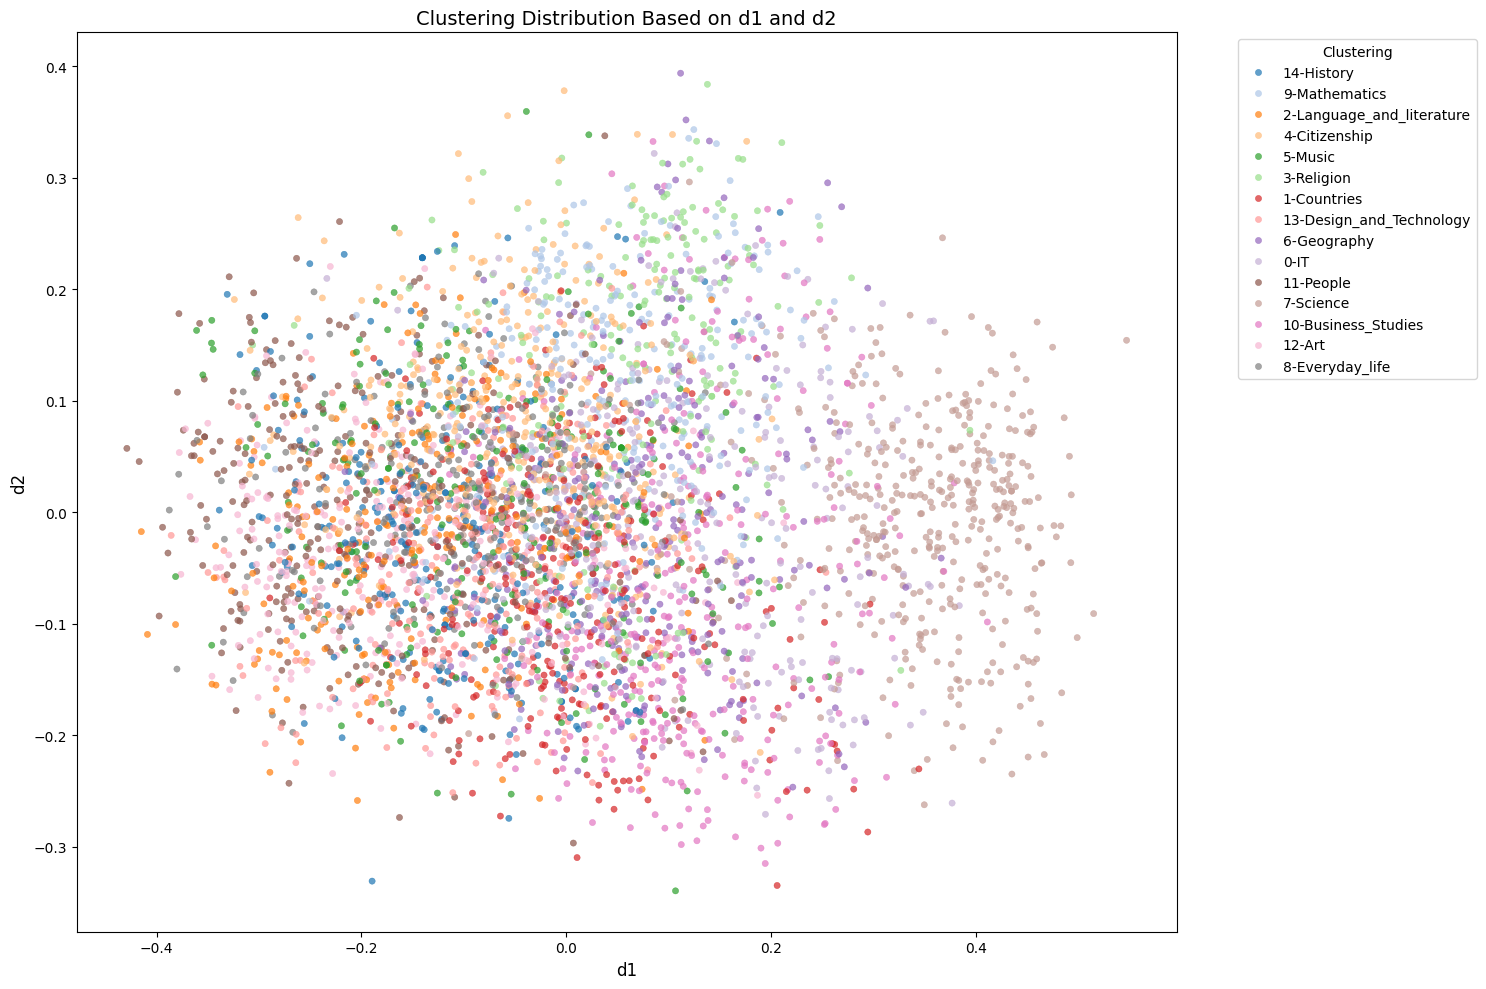

In [7]:
plot_clustering_distribution(mpnet_values, mpnet_clustering, mpnet_mapping, d1=0, d2=7)

#### 1.1.5. Visualize the clustering result

Path length counts:
path_length
3     3424
4     8558
5    10941
6     8137
7     5868
8     3954
9     2650
Name: count, dtype: int64


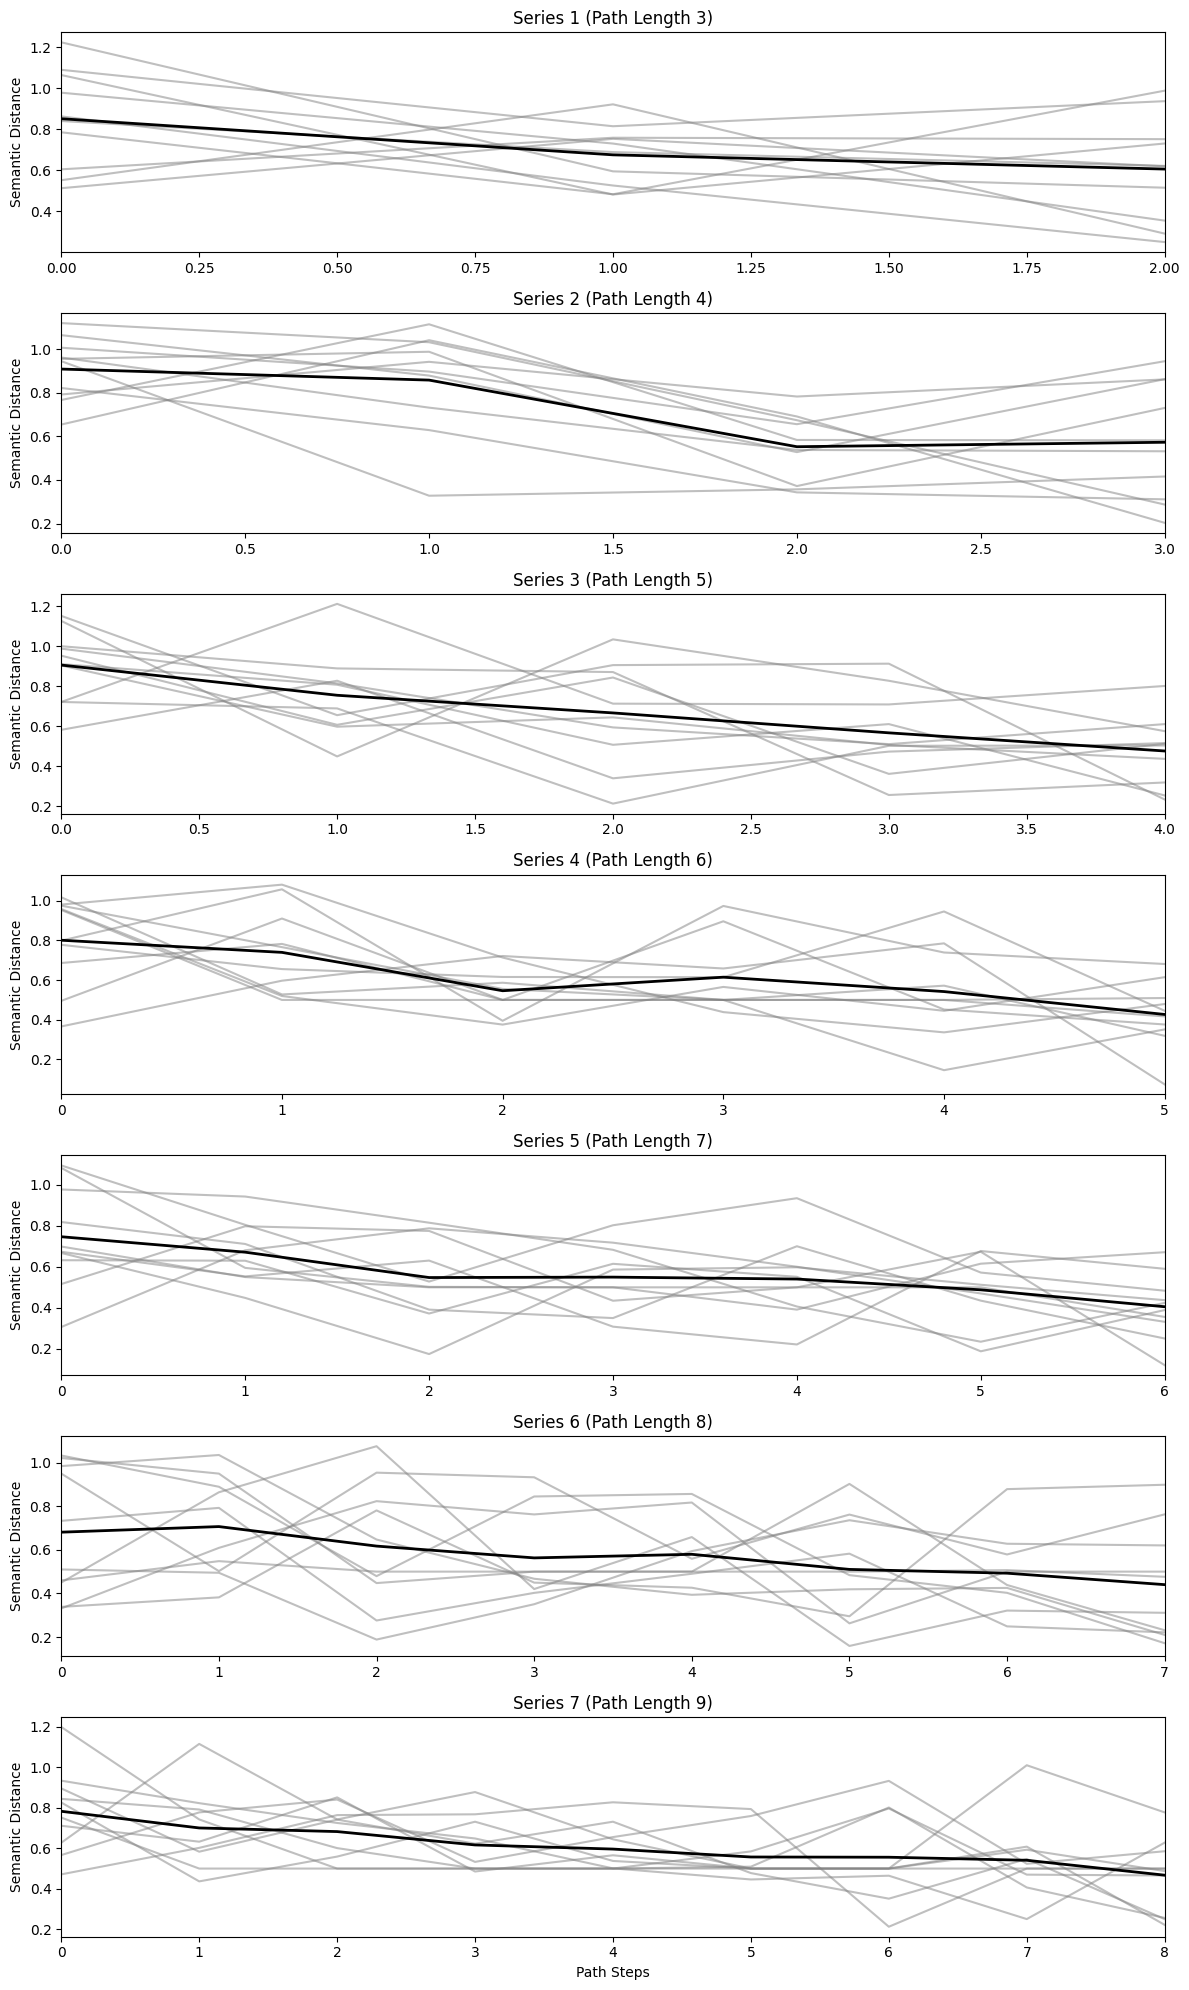

In [8]:
distance_df, path_df, sampled_paths = analyze_semantic_distances(mpnet_embedding, "data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv")

#### 1.1.6. Generate semantic distance for all paths

In [9]:
process_path_data(path_df, distance_df, "data/semantic/semantic_mpnet.csv")

Data successfully saved to data/semantic/semantic_mpnet.csv


### 1.2. Implementation of paper's distance

this is an attempt at reimplementing the semantic distance between wikipeedia articles presented in [West, Pineau, Precup ; Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts](http://infolab.stanford.edu/~west1/pubs/West-Pineau-Precup_IJCAI-09.pdf)

And we offer a subjective evaluation simulating the human expert evaluation in paper

#### 1.2.1. Implementation

we are interested in P(A′ |A = a, G = g): For each article a′ that can be reached in one hop from a, the probability that a player continues to a′ if he/she is currently on a and is trying to find goal article g

This can be estimated from the observed games using standard Bayesian methods, as the mean of the Dirichlet distribution which is the conjugate prior of P(A′ |A = a, G = g)

We use P∗ to denote the posterior click probability estimated after seeing all the data: P∗(A′ = a′ |A = a, G = g) = (N(A′ = a′, A = a, G = g) + α) / (N(A = a, G = g) + αL_a)

51318 paths processed.


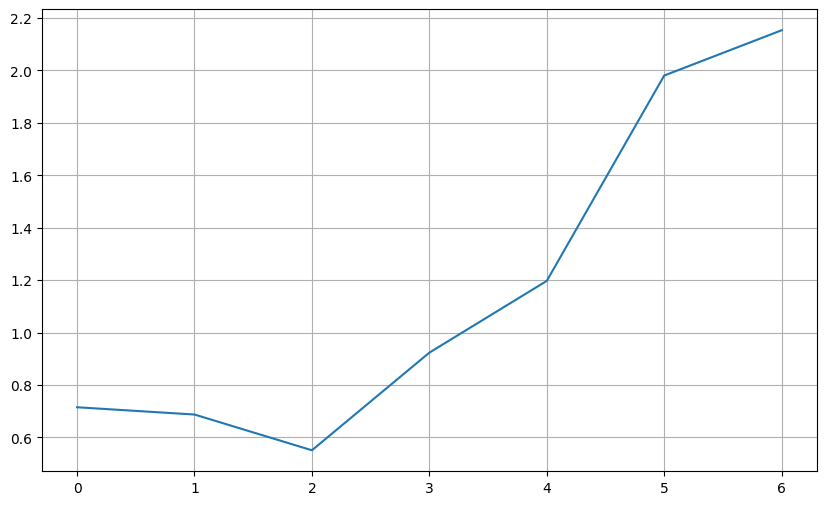

In [10]:
# Example usage
articles_path = "data/original_dataset/wikispeedia_paths-and-graph/articles.tsv"
paths_path = "data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv"
links_path = "data/original_dataset/wikispeedia_paths-and-graph/links.tsv"

process_wikispeedia_data(articles_path, paths_path, links_path)

Information gain above

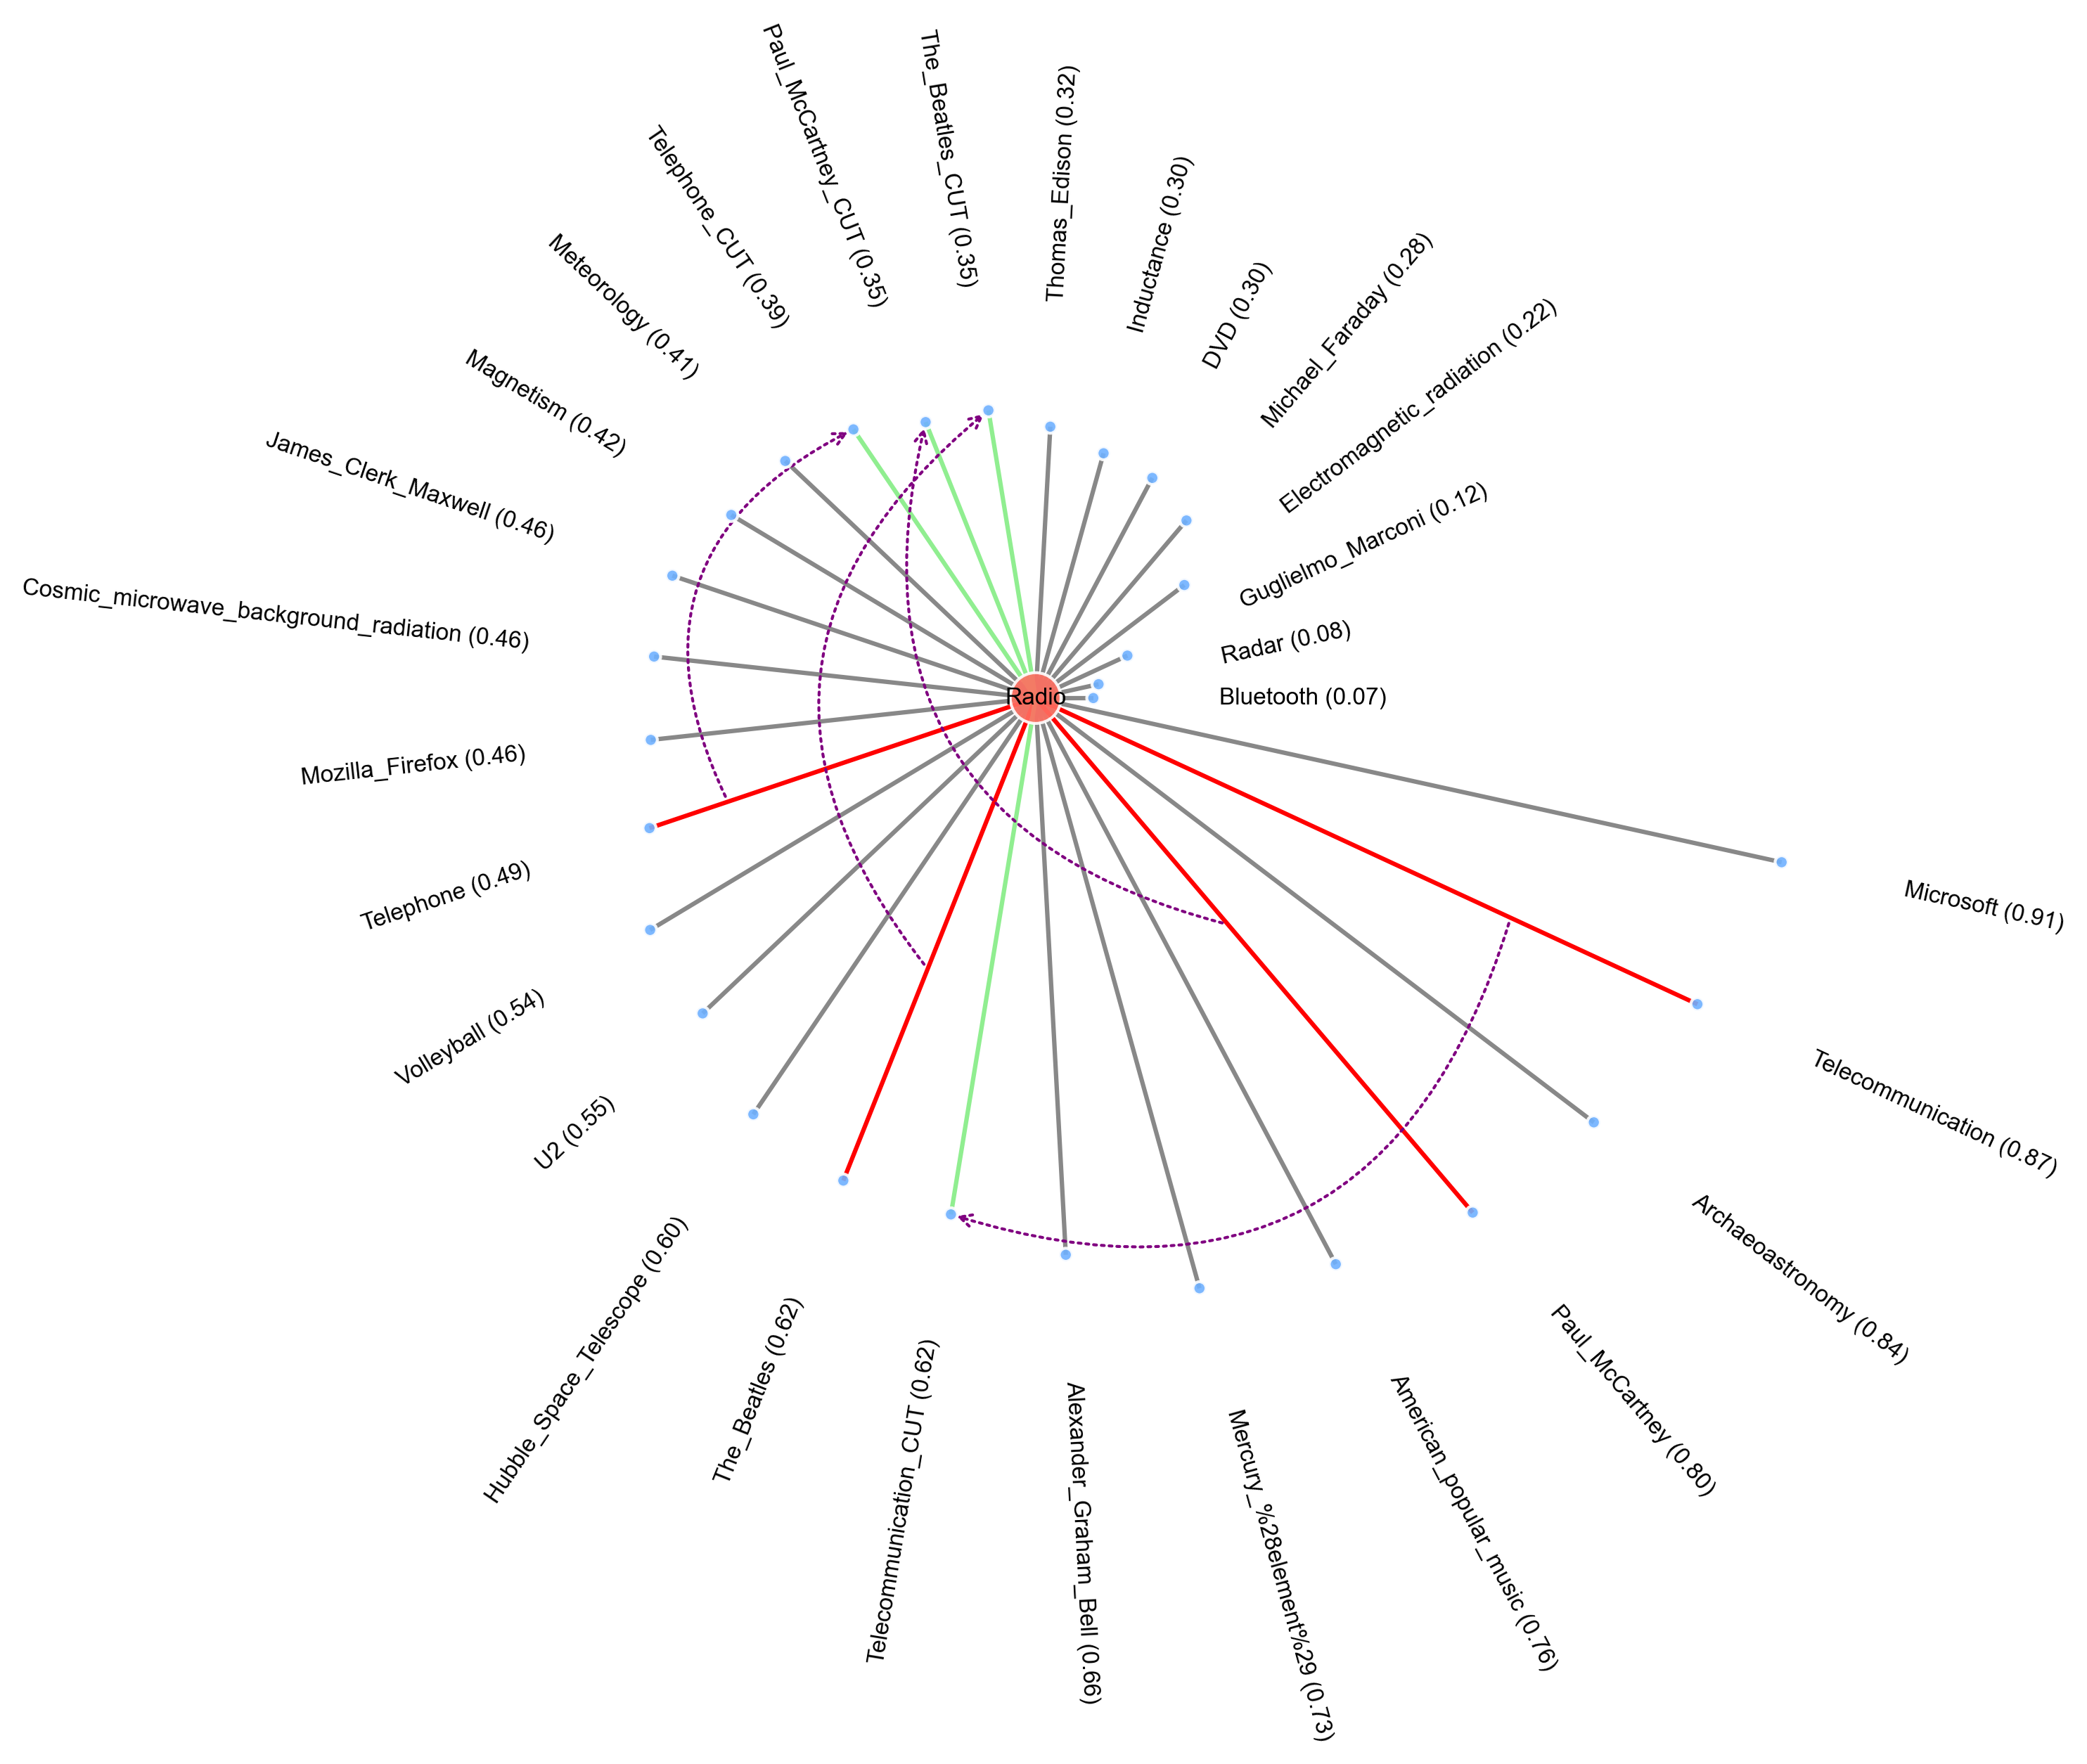

In [11]:
visualize_distance_graph(
    main_node="Radio",
    samples=25,
    random_state=19,
    distance_file="data/semantic/distances.csv",
    filtered_file="data/semantic/distances_filtered.csv"
)

#### 1.2.2. Evaluation

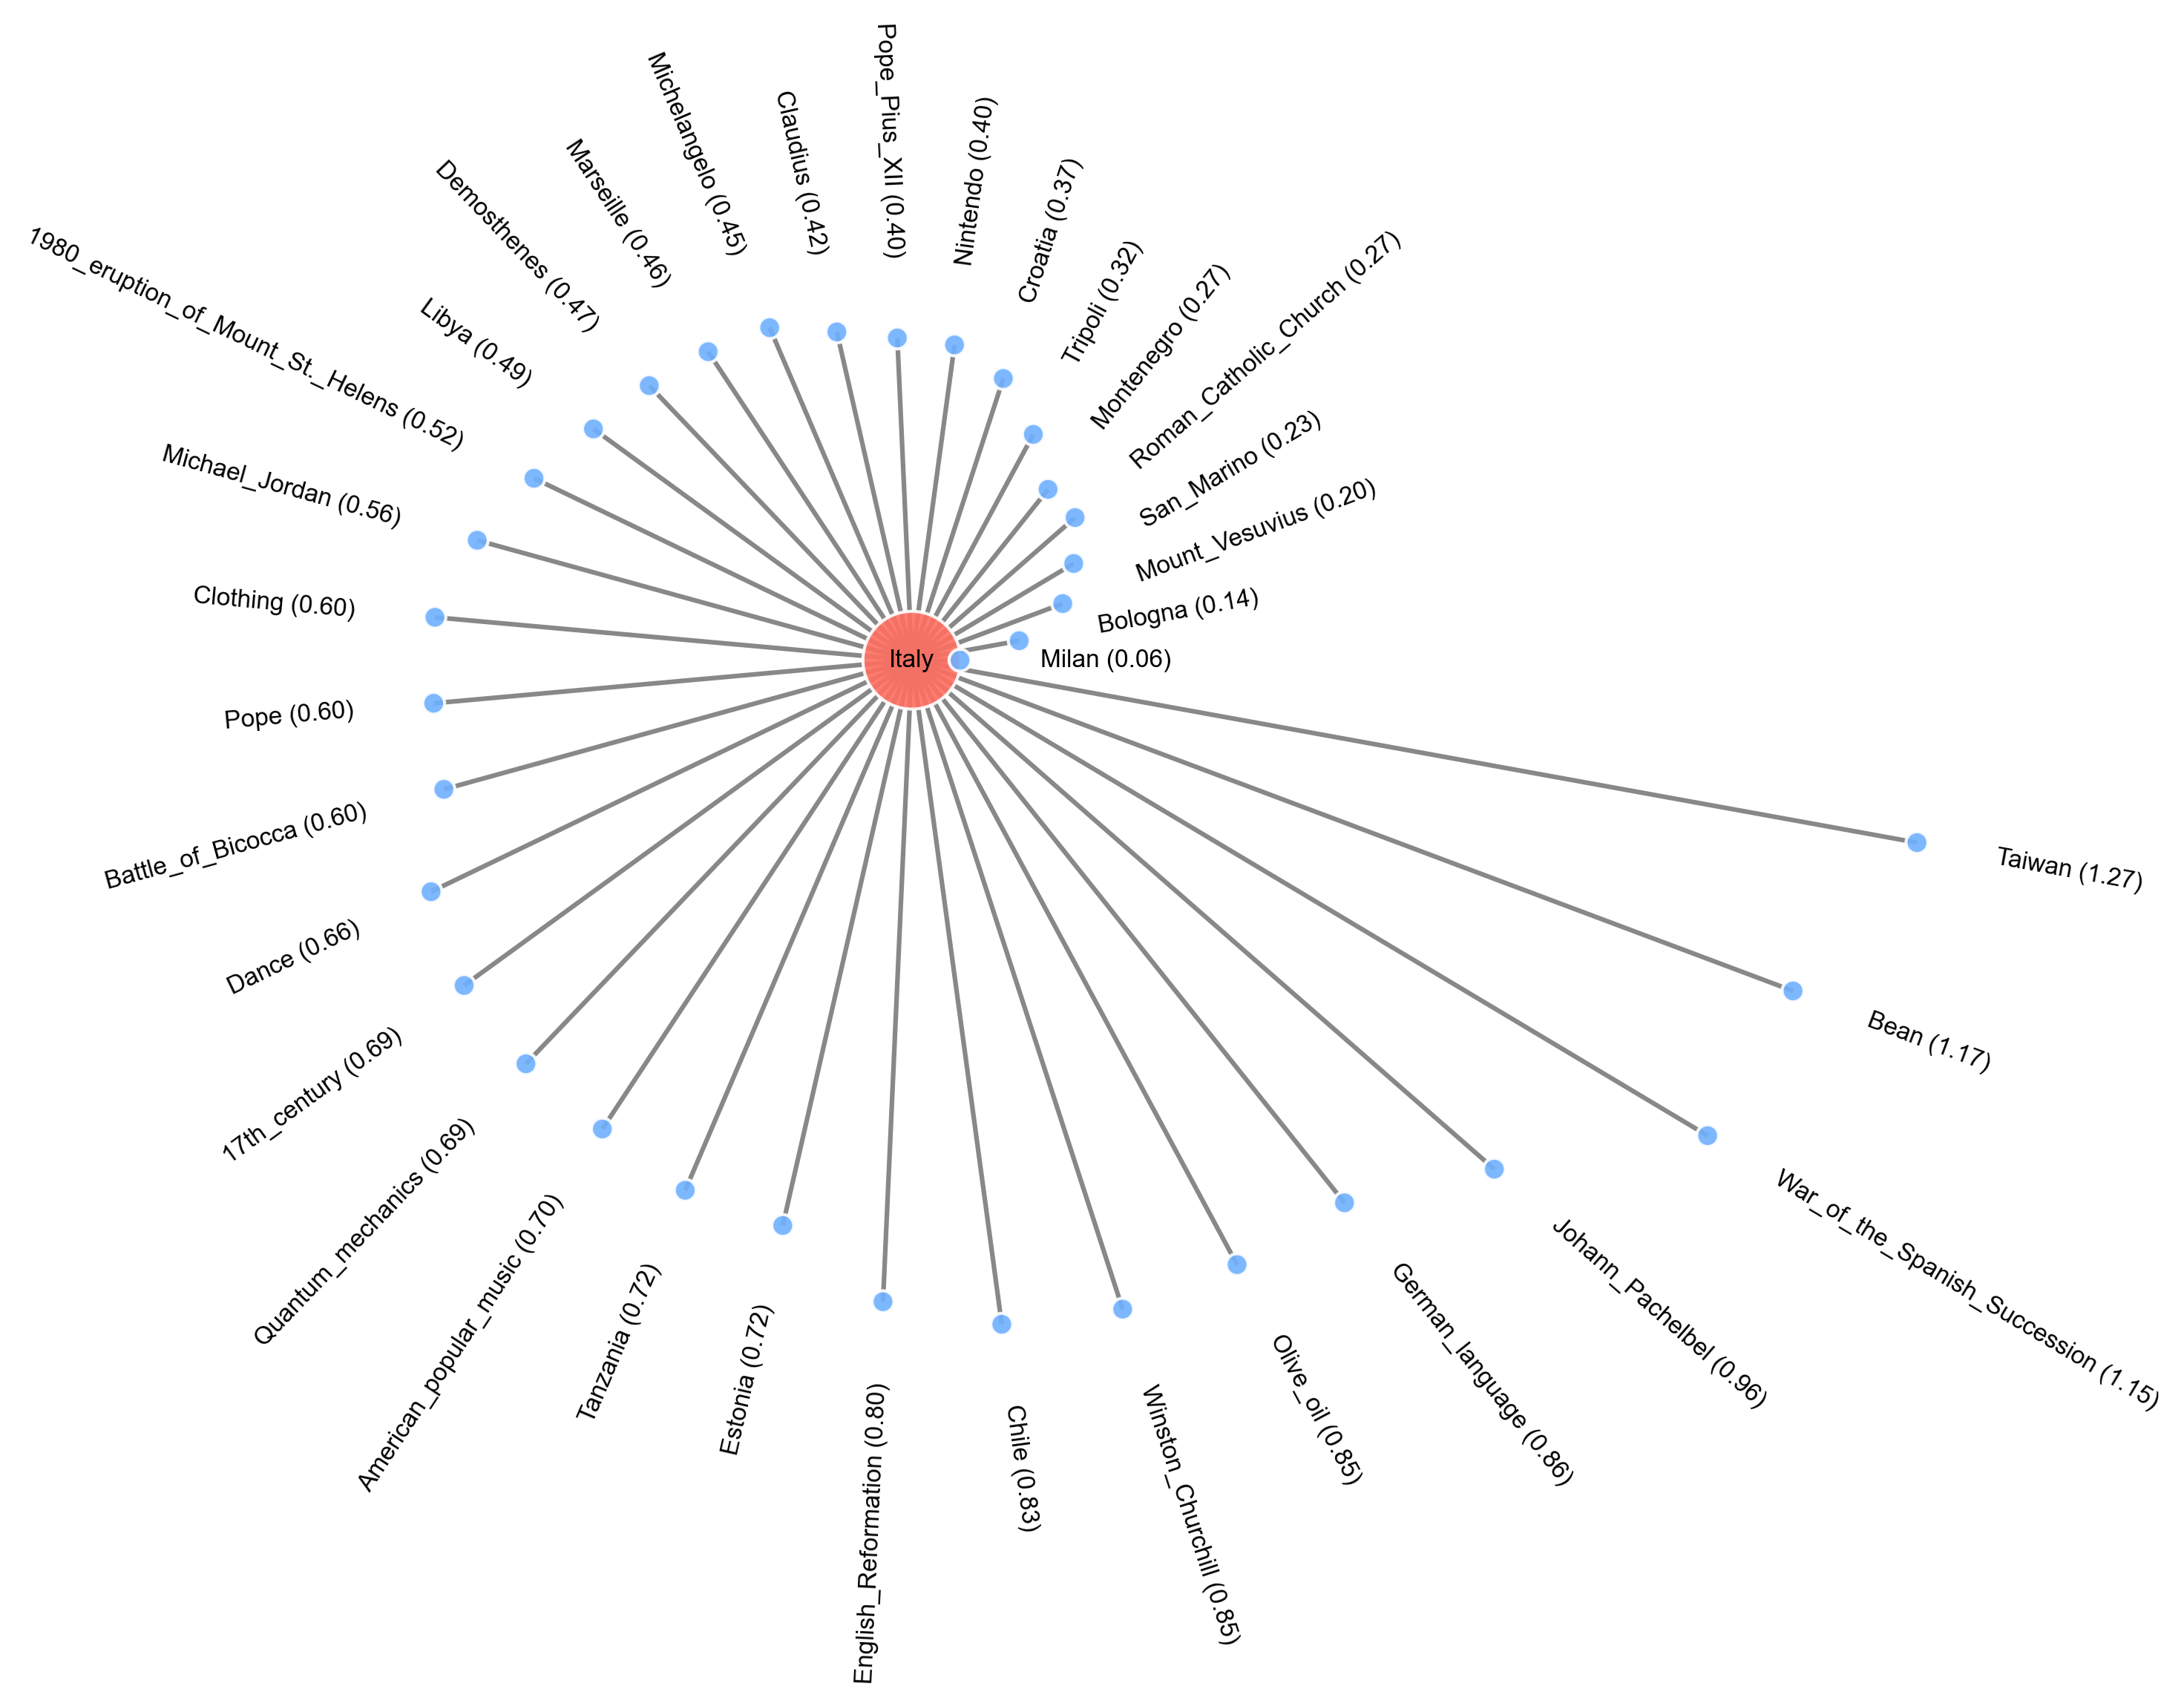

In [12]:
plot_semantic_network(
    csv_path="data/semantic/distances_filtered.csv",
    main_node="Italy",
    samples=35,
    random_state=139,
    distance_scale_factor=2.0
)

## 2. Attention Oriented Emotion Labeling

### 2.1. HTML Content Preprocessing and Extraction with Hyperlink Preservation

This part we first extracts semantic segments from HTML files of all webpages, and define and calculate weighted emotion scores based on human reading attentioen on hyperlink and increasing sparsity.

We considered the action of \
•	Lemmatization: Reduces words to their base form (e.g., “running” to “run”). \
•	Stemming: Trims words to their root (e.g., “jumps” to “jump”).

Benefits of Lemmatization and Stemming in Sentiment Analysis

1.	Both lemmatization and stemming reduce words to a common form, which can help models by reducing vocabulary size and focusing on the base meaning of words. For instance, “amazing” and “amazingly” become “amaz,” which may help a simpler model recognize these as similar in sentiment.
2.	Reducing Noise: Variations in verb tenses or plural forms don’t usually impact sentiment. By simplifying “running,” “ran,” and “runs” to “run,” the model can better focus on the emotional content of the words rather than linguistic variations.

Drawbacks of Lemmatization and Stemming

1.	Loss of Nuance: Stemming, in particular, can lead to words losing critical distinctions. For example, “happy” and “happiness” might both be stemmed to “happi,” which removes any slight difference in meaning or intensity that could be relevant to sentiment.
2.	Complicated Sentiment Contexts: Certain suffixes can carry sentiment information. For instance, “help” (neutral) versus “helpful” (positive). Stemming might remove these subtle distinctions, potentially reducing accuracy.

However, for transformer models (e.g., BERT, RoBERTa) or when working with models trained on large datasets, as these models already account for nuanced variations. Modern models handle token variations well, and stemming can reduce performance by discarding subtle context. Therefore, lemmatization alone might be a safer choice than stemming. It preserves word meaning more accurately, while still standardizing some forms. Stemming might only be beneficial for smaller, less nuanced datasets where word reduction is crucial.

Hence, we only perform lemmatization here.

Extracts readable text from HTML content while preserving hyperlinks. The anchor tags in the HTML content will be converted to a format that includes the anchor text and URL in the form `[anchor_text](URL)`. The function splits the text into sentences to make it more aligned with natural reading behavior.

In [13]:
# Show three html files after extracting sentences
extract_sentences('data/original_dataset/wpcd/wp').head(3) 

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,721,722,723,724,725,726,727,728,729,730
0,Royal_Marines.htm,Royal Marines Royal Marines [ 2007 Schools Wik...,Related subject : [ Military History and War ]...,A core component of the country 's Rapid Deplo...,"The high level of training and competence , co...",The Royal Marines are a component part of the ...,Role Corps of Royal Marines Cap Badge of the R...,As the United Kingdom Armed Forces ' specialis...,In common with the other armed force the Royal...,"Command , Control and Organisation Command of ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Recycling.htm,Recycling Recycling [ 2007 Schools Wikipedia S...,Related subject : [ Environment ] ( URL ) [ ] ...,[ Environmental science ] ( URL ) Environmenta...,Recycling prevents useful material resource be...,Recycling is a key concept of modern [ waste m...,"Recyclable material , also called `` recyclabl...","They include [ glass ] ( URL ) , paper , [ alu...","Biodegradable waste , such a food waste or gar...",Recyclates need to be sorted and separated int...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Retreat_of_glaciers_since_1850.htm,Retreat of glacier since 1850 Retreat of glaci...,Related subject : [ Climate and the Weather ] ...,"Studied by glaciologists , the temporal coinci...",Mid-latitude mountain range such a the [ Himal...,The Little Ice Age wa a period from about 1550...,"Subsequently , until about 1940 glacier around...","Glacial retreat slowed and even reversed , in ...","However , since 1980 a significant global warm...",In location such a the Andes of [ South Americ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2. Attention Span Weight Calculation

#### 2.2.1. Link Attention Modelling

First we will generate a dictionary the contains the count of each linked link corresponding with each target.

Reasoning:
> To model human attention in navigation, we hypothesize that a human navigator is likely to focus more on links or titles that are relevant to their end goal, or target article. By examining real human behavioral data, we can derive a dictionary that quantifies the frequency of articles encountered on the way to each target article. This dictionary serves as an indicator of the correlation between each intermediate link/title and the target article.

> This correlation relationship gives insight into a human's inclination to choose specific links or titles based on their relevance to the target. In other words, the more frequently an article appears in paths leading to a particular target, the more likely it reflects a natural inclination or preference in human navigation behavior. The unclicked links will share the same ambigutious / preassumed inclination.

In [14]:
# generate a frequency dictionary of links between articles on user paths, and show one readable example
generate_link_freq_dict('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv')

{'African_slave_trade': {'14th_century': 2, 'Europe': 3, 'Africa': 16, 'Atlantic_slave_trade': 18, ......}


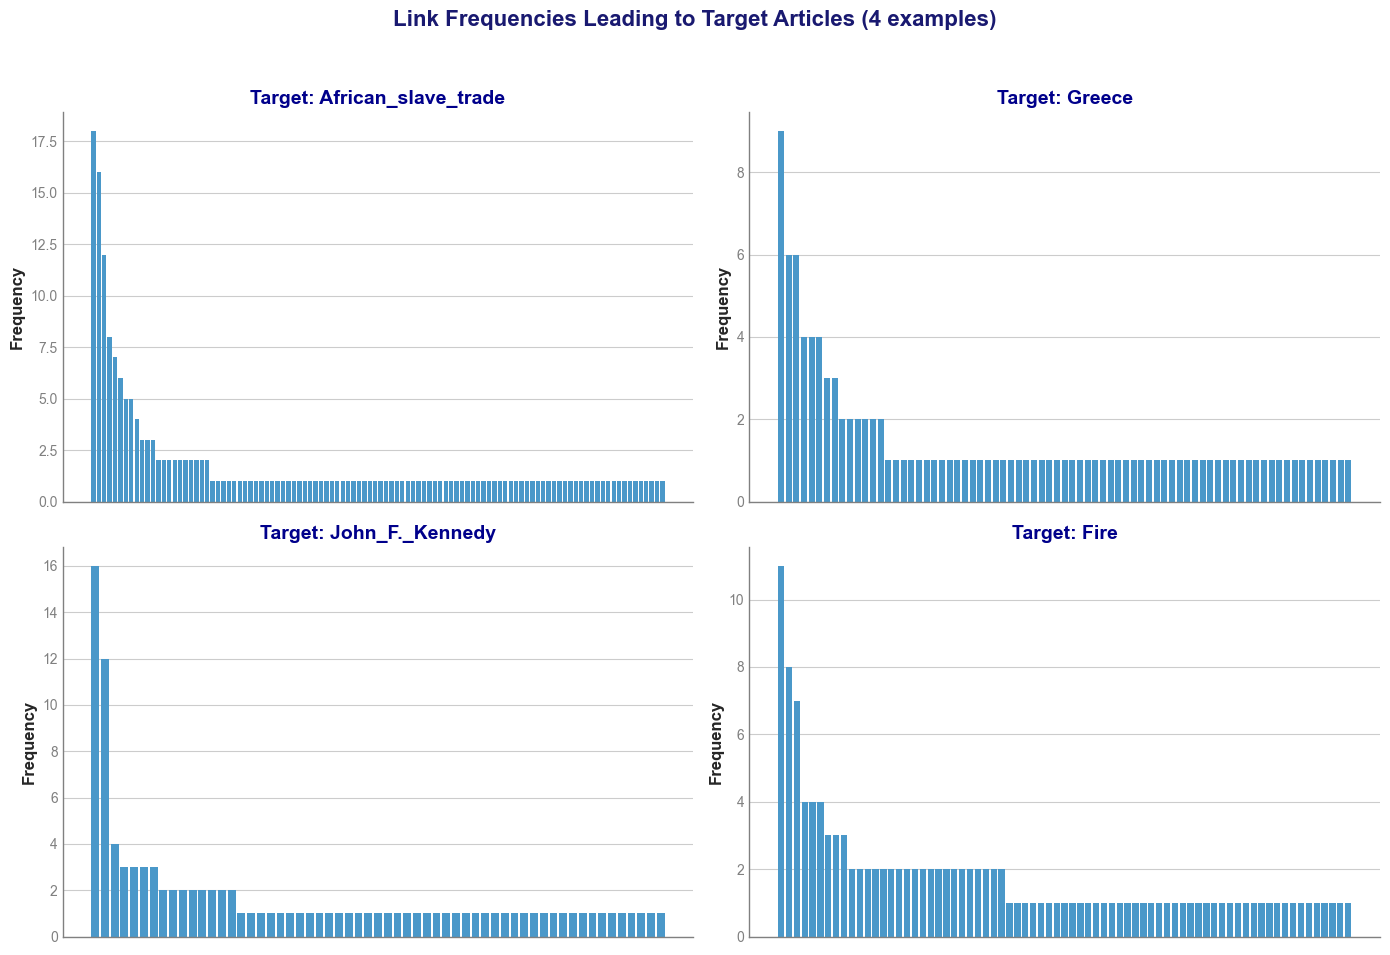

In [15]:
# plot the distribution of links frequencies leading to target articles for further exploration
plot_link_frequencies('data/emotion/link_freq_dict.json')

Exponential Distribution of Frequencies: 
 
In each target’s subplot, the frequencies of articles leading to the target display an exponential-like property: a small number of articles have high frequencies, while most other articles appear less frequently. This indicates that users tend to follow a few common paths when navigating to a target, suggesting a strong preference for specific links that are likely perceived as highly relevant to the end goal.

#### 2.2.2. Sentence Weight Assignment

To model user attention, we assume that users are more likely to focus on links within sentences, as these links serve as potential pathways to reach their target. Therefore, sentences containing links (`[ anchor_text ] ( URL )`) are assigned relatively higher weights than those without links, which share a baseline weight.

In addition, we use link click frequency as an indicator of the attention drawn by each link. Links that have been clicked more frequently are likely to be perceived as more relevant or interesting, indicating a higher level of attention from users. Consequently, the weight for each link is proportional to its click frequency, and links with higher click frequencies are assigned greater weights than those with no recorded clicks.

The weight assignment method is formalised as following:

> Mathematical Expression for Sentence Weight Assignment

To model sentence weight based on link presence and click frequency, we define the following:

1. Let $S$ be a sentence.
2. Let $L_i$ represent each link in sentence $S$, where $i = 1, 2, \ldots, n$ (if there are $n$ links in the sentence).
3. Let $f(L_i)$ denote the click frequency of link $L_i$.
4. Let $W_{baseline}$ represent the baseline weight assigned to sentences with no links.

> Weight Assignment Formula

The weight $W(S)$ for sentence $S$ is assigned as follows:

1. **If $S$ contains no links**, assign a baseline weight:
   $$
   W(S) = W_{\text{baseline}}
   $$

2. **If $S$ contains links**, the weight of $S$ is calculated based on a normalized sum of the click frequencies for the links in $S$:
   $$
   W(S) = W_{\text{baseline}} + k \cdot \sum_{i=1}^n \frac{f(L_i)}{\text{\#links for target}}
   $$
   where:
   - $W_{\text{baseline}}$ is the baseline weight for sentences without links.
   - $k$ is a proportionality constant that scales the contribution of click frequency to the overall sentence weight.
   - $f(L_i)$ represents the click frequency of link $L_i$.
   - $\text{\#links for target}$ is the total sum of click frequencies for all links leading to the specified target.


> Explanation of the Formula

- **Baseline Weight $W_{\text{baseline}}$**: Ensures that every sentence has a minimum weight, even if it contains no links.
- **Click Frequency Contribution**: The term $\sum_{i=1}^n k \cdot f(L_i)$ increases the weight for sentences containing links based on how frequently those links are clicked. The higher the frequency $f(L_i)$ for a link, the greater the weight for the sentence, reflecting increased user attention.
- **Normalization Term $\frac{f(L_i)}{\text{\#links for target}}$**: Each link’s frequency $f(L_i)$ is divided by the total click frequency for the target, ensuring that frequencies are comparable across targets with varying link counts.
- **Scaled Contribution**: The normalized click frequencies are scaled by $k$ and summed for each link in the sentence, providing an overall attention weight that reflects user focus based on link relevance and frequency.


This formula prioritizes sentences with high-frequency links, aligning with the assumption that frequently clicked links draw more user attention.

Relevant literature that justifies the choice above: 
> Kahneman, D. (1973). Attention and Effort. Prentice-Hall. This classic work emphasizes that attention is a limited resource and is selectively allocated to elements that are most informative or engaging.

Proportionality Constant ( $k$ ): This value ensures that while links with high click frequencies (popular or frequently chosen links) increase sentence weight significantly, the scaling remains moderate to reflect that human attention, even when selectively focused, tends to spread across multiple cues rather than concentrating exclusively on a single feature.

> Treisman, A. M., & Gelade, G. (1980). A feature-integration theory of attention. Cognitive Psychology, 12(1), 97-136. This study suggests that attention is directed based on feature saliency, but that it distributes across multiple features, particularly in complex tasks.

#### 2.2.3. Handling Backtracking in Path Analysis: Considerations for Emotional Analysis

In analyzing navigation paths, we must consider how to handle backtracking steps (represented by `<`). Backtracking occurs when users navigate back to a previous article, which can provide valuable insights into their exploratory behavior but may also introduce noise. Here, we explore two approaches: **removing backtracking** and **replacing backtracking with the previous article**. Each approach has unique implications for emotional analysis and the relationship between emotion change and semantic distance.

##### 1. Removing Backtracking
In this approach, all instances of `<` are removed from the path, resulting in a streamlined path sequence without backtracking steps.

**Pros**:
- **Cleaner Path Sequence**: Removing backtracking provides a straightforward path, showing only forward progression. This is beneficial when the focus is on direct associations between consecutive articles.
- **Simplified Emotional Analysis**: Without backtracking, emotional analysis can focus purely on the progression of emotions as users encounter new topics. This can make patterns in emotion change easier to identify and analyze.

**Cons**:
- **Loss of Exploration Behavior**: By removing backtracking, we lose information about the user’s exploratory behavior, which might be relevant to understanding emotional responses to content revisitation.
- **Potential Loss of Emotional Nuance**: Backtracking could indicate repeated exposure to emotionally charged topics. Without it, we might miss certain patterns in emotional reactions tied to revisiting previously encountered topics.

##### 2. Replacing Backtracking with the Previous Article
In this approach, each `<` is replaced with the last visited article, effectively duplicating articles in the path to indicate when users revisit content.

**Pros**:
- **Insight into Exploratory Patterns**: This approach preserves the user’s backtracking behavior, which may reveal exploratory or confirmatory patterns. These patterns could indicate deeper engagement with certain topics or themes.
- **Enhanced Emotional Analysis**: Repeated articles in the path allow us to track emotional responses to revisited content, which might reflect sustained or heightened emotions. For example, revisiting a topic with strong emotional content could amplify or stabilize the user’s emotional state.

**Cons**:
- **Increased Path Complexity**: Backtracking introduces additional steps in the path, which could complicate the analysis by increasing the number of steps and potentially diluting clear patterns in emotional progression.
- **Potential Noise in Emotional Trends**: If users frequently backtrack to neutral or less significant content, it could introduce noise in emotional trends, making it harder to distinguish meaningful emotional changes.

##### Relationship Between Emotion Change and Semantic Distance

The choice between removing or preserving backtracking also impacts the analysis of **emotion change in relation to semantic distance** between articles:
- **Removing Backtracking** emphasizes the semantic distance between new topics, allowing us to examine how emotional responses shift with each novel topic encountered.
- **Preserving Backtracking** captures both semantic proximity (revisiting the same topic) and changes over time, allowing for a more detailed study of how repeated exposure to specific content influences emotion.

By analyzing emotion change in conjunction with semantic distance, we can assess how users’ emotions evolve as they navigate through increasingly different (or similar) topics. This approach could reveal patterns such as emotional intensification with greater semantic distance or stabilization with repeated exposure.

In summary, each approach offers unique insights, and the best choice depends on the focus of the analysis:
- **Without Backtracking** is ideal for studying direct emotional progression across diverse topics.
- **With Backtracking** is suitable for understanding how emotional responses are influenced by topic revisitation and exploratory behavior.

In [16]:
path_df_no_backtracking = extract_path_data('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='remove')
path_df_with_backtracking = extract_path_data('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='replace')

Paths have been extracted and saved to data/emotion/extracted_paths_no_backtracking.csv
Paths have been extracted and saved to data/emotion/extracted_paths_with_backtracking.csv


#### 2.2.4. Weighted Emotion Scores

Now that each sentence has an associated emotion label, we can calculate a weighted emotion score for each sentence. This score combines the previously calculated attention weight of the sentence with its emotion label, providing a more nuanced view of the emotional significance based on user attention.

Let:
- $W(S)$ be the attention weight of sentence $S$, calculated as described previously.
- $E(S)$ be the emotion label (or emotion score) associated with sentence $S$.

The weighted emotion score for each sentence $S$ is calculated as:
$$
\text{E}_{weighted}(S) = W(S) \cdot E(S)
$$

This weighted emotion score provides a refined measure that accounts for both the emotional tone of the sentence and the likelihood that it will capture attention.

#### 2.2.5. Increasing Reading Sparsity: Nested Macro Average 

To account for the nature of reading sparsity, we will calculate a **Nested Macro Average** of weighted emotion scores by progressively grouping sentences. This approach reflects the likelihood that readers pay more attention to earlier sentences and progressively less to later sections.

##### Grouping Structure for Nested Macro Average

The weighted emotion scores are grouped as follows:
1. The first sentence alone: $[1]$
2. The second and third sentences together: $[2, 3]$
3. The fourth, fifth, and sixth sentences together: $[4, 5, 6]$
4. The seventh through tenth sentences together: $[7, 8, 9, 10]$
5. Continue grouping in this nested manner, with each subsequent group containing one additional sentence.

##### Steps for Calculating the Nested Macro Average

1. **Calculate the Weighted Emotion for Each Group**: For each group, calculate the average weighted emotion score within the group.
   
2. **Average the Grouped Scores**: After calculating the average for each group, take the average of these grouped scores to obtain the final Nested Macro Average.


Let:
- $W\_E(S_i)$ represent the weighted emotion score of sentence $S_i$.
- Groups are defined as $G_1 = [S_1]$, $G_2 = [S_2, S_3]$, $G_3 = [S_4, S_5, S_6]$, $G_4 = [S_7, S_8, S_9, S_{10}]$, and so forth, with each subsequent group expanding by one additional sentence.

The **Nested Macro Average** is calculated as:
$$
\text{Nested Macro Average} = \frac{1}{k} \sum_{j=1}^k \left( \frac{\sum_{i \in G_j} W\_E(S_i)}{|G_j|} \right)
$$
where:
- $k$ is the total number of groups,
- $G_j$ is the $j$-th group of sentences,
- $|G_j|$ is the number of sentences in group $G_j$,
- $\sum_{i \in G_j} W\_E(S_i)$ represents the sum of weighted emotions within group $G_j$.

This formula averages the weighted emotions within each group and then takes the overall average across groups. By weighting the earlier sentences more heavily, this approach provides a balanced measure that reflects both the emotional tone and the attentional distribution across the article.

In [17]:
# Load the CSV files into DataFrames
unweighted_emotion = pd.read_csv('data/emotion/unweighted_emotion_article.csv')
paths_backtracking = pd.read_csv('data/emotion/extracted_paths_with_backtracking.csv')
paths_nonbacktracking = pd.read_csv('data/emotion/extracted_paths_no_backtracking.csv')
click_frequencies = 'data/emotion/link_freq_dict.json' 
sentences = pd.read_csv('data/emotion/extracted_sentences.csv', index_col=0)
sentences.index = sentences.index.map(lambda x: re.split(r'\.html?$', str(x))[0] if isinstance(x, str) else x) # cases such as U.S._state.htm can be dealed correctly.

In [18]:
unweighted_emotion.head(1)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,721,722,723,724,725,726,727,728,729,730
0,Royal_Marines,"[[{'label': 'neutral', 'score': 0.959148228168...","[[{'label': 'neutral', 'score': 0.950789213180...","[[{'label': 'neutral', 'score': 0.838996231555...","[[{'label': 'admiration', 'score': 0.553389370...","[[{'label': 'neutral', 'score': 0.903455257415...","[[{'label': 'neutral', 'score': 0.952531218528...","[[{'label': 'neutral', 'score': 0.750821828842...","[[{'label': 'neutral', 'score': 0.814710736274...","[[{'label': 'neutral', 'score': 0.947301447391...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we used **roberta-base-go_emotions** for 28 emotion annotation and we consider both human attention span and reading sparsity for each article in each navigation path for each path. And here is an example for one path and one emotion.

In [19]:
# Test the function with a single path
first_row = paths_backtracking.iloc[0]
target = first_row['target']
path = first_row.drop(labels=['target']).dropna().tolist()

# Calculate the weighted emotions for this single path for the 'surprise' emotion
weighted_path_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, click_frequencies, emotion_type='surprise')

print(weighted_path_df)

                target    Step_1    Step_2    Step_3    Step_4    Step_5  \
0  African_slave_trade  0.000339  0.000287  0.000306  0.000208  0.000251   

     Step_6    Step_7    Step_8  
0  0.000211  0.000292  0.000272  


### 2.3 Result showcase

Now we can do the calculation through all emotions on all paths. For this semester project, we only consider backtracking paths and we only proceed on two emotions: 'surprise' and 'curiosity' for our further discussion. (Each emotion will cause 10+ hours for calculating.)

In [20]:
backtracking_path_weighted_emotions_surprise_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_surprise.csv').drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_curiosity.csv').drop(columns=['path_index'])

In [21]:
backtracking_path_weighted_emotions_surprise_df.head(3) # Display the DataFrame for surprise emotion

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000339,0.000287,0.000306,0.000208,0.000251,0.000211,0.000292,0.000272,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000339,0.000246,0.000292,0.000272,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000339,0.000291,0.000337,0.000289,0.000186,0.000292,0.000272,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3.1. Showcase by differnt length

In [22]:
# we print out the portion of lengths of the paths to see the distribution, and we select a reasonable range to showcase for the rest of the analysis
show_paths_lengths(backtracking_path_weighted_emotions_surprise_df, start_step=1, end_step=11)

Path lengths:
Length of paths 2: 798
Length of paths 3: 3424
Length of paths 4: 8558
Length of paths 5: 10941
Length of paths 6: 8137
Length of paths 7: 5868
Length of paths 8: 3954
Length of paths 9: 2650
Length of paths 10: 1713
Length of paths 11: 1256


We chose the length of paths from 4 to 7 for further analysis. We first randomly draw 10 samples of each size (those samples are aligned with the semantic distance by setting the seeding the same)

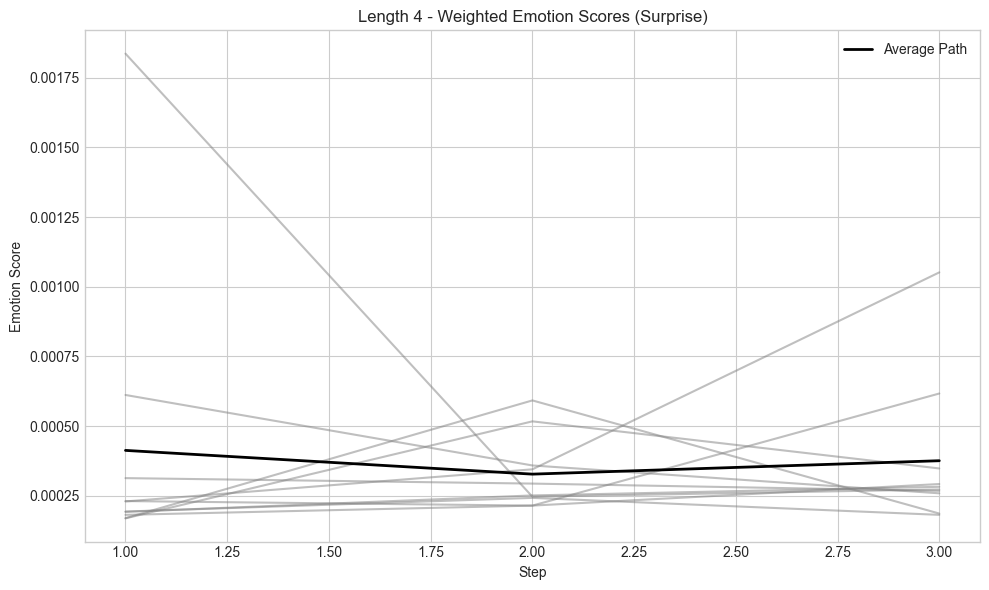

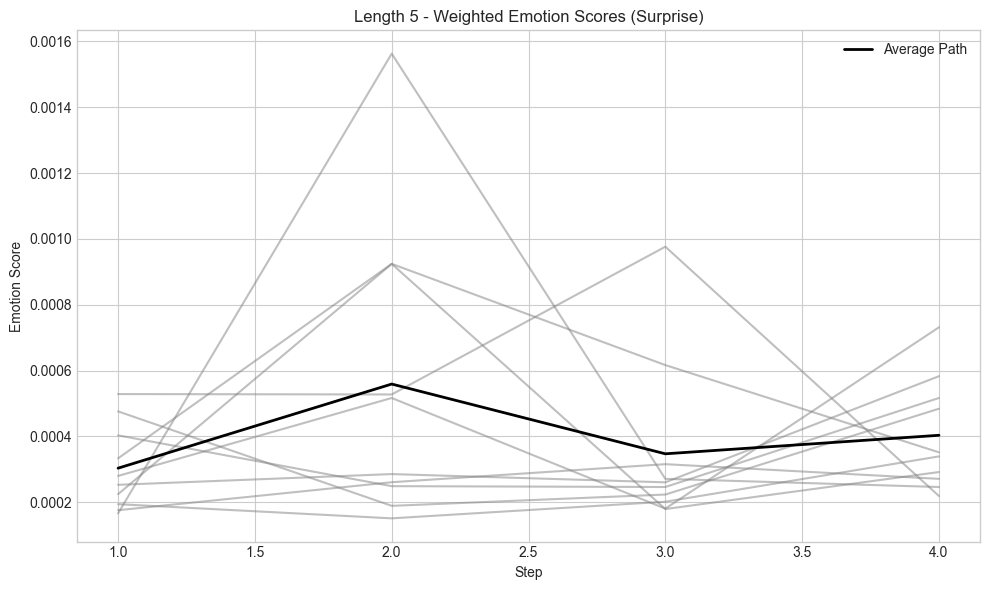

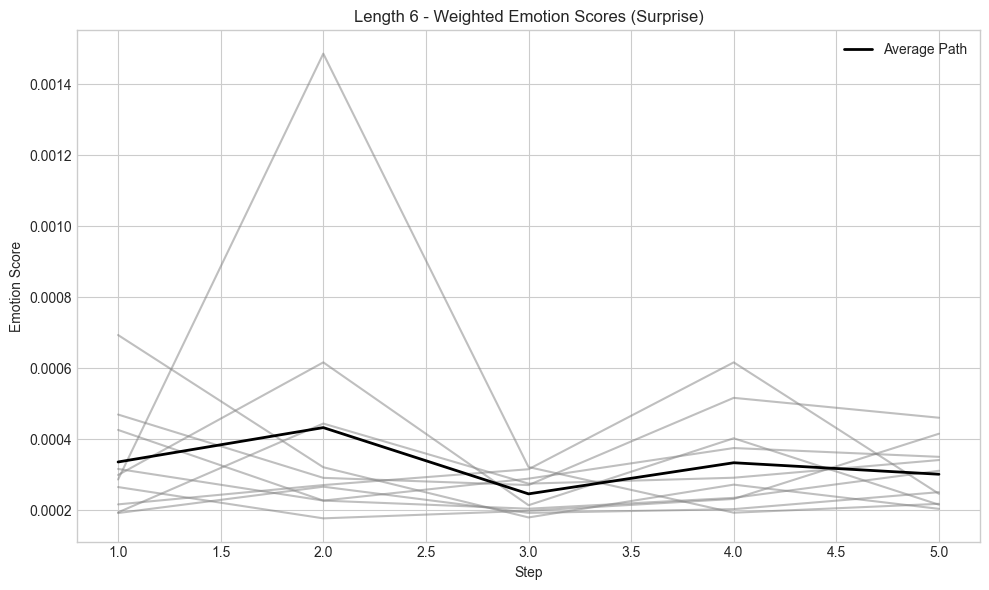

In [23]:
plot_paths_with_random_samples(backtracking_path_weighted_emotions_surprise_df, emotion_label="Surprise", lengths=range(4,7))


#### 2.3.2. Showcase of correlation of emotions

In [24]:
# Analyze the correlation between emotions in navigation paths.
analyze_correlation(backtracking_path_weighted_emotions_surprise_df, 
    backtracking_path_weighted_emotions_curiosity_df, 
    high_corr_threshold=0.7)

Top 5 num_steps values with the highest count of highly correlated routes:
   num_steps  count
0          3   4360
1          4   3445
2          2   3424
3          5   1826
4          6   1113


{'num_highly_correlated_routes': 15781,
 'surprise_high_corr_portion': 0.21893995803154404,
 'curiosity_high_corr_portion': 0.21893995803154404,
 'top_5_high_steps':    num_steps  count
 0          3   4360
 1          4   3445
 2          2   3424
 3          5   1826
 4          6   1113}

As we can see lengths 4,5,6 all have descent portion.
we can scale it to more.

#### 2.3.3. Emotion Jump

In [25]:
#Surprise
data_path_surprise = 'data/emotion/surprise_emotion_relative_jump_rates.csv' # output path
surprise_jump_df = calculate_emotion_jump_rates(
    backtracking_path_weighted_emotions_surprise_df, 'Surprise', data_path_surprise
)

#Curiosity
data_path_curiosity = 'data/emotion/curiosity_emotion_relative_jump_rates.csv' # output path
curiosity_jump_df = calculate_emotion_jump_rates(
    backtracking_path_weighted_emotions_curiosity_df, 'Curiosity', data_path_curiosity
)

Saved: data/emotion/surprise_emotion_relative_jump_rates.csv
   path_index  small_jumps  medium_jumps  large_jumps  total_jumps
0           0            2             5            0            7
1           1            1             2            0            3
2           2            1             4            1            6
3           3            1             1            0            2
4           4            1             2            2            5
Saved: data/emotion/curiosity_emotion_relative_jump_rates.csv
   path_index  small_jumps  medium_jumps  large_jumps  total_jumps
0           0            1             4            2            7
1           1            0             2            1            3
2           2            0             2            4            6
3           3            0             0            2            2
4           4            1             2            2            5


## 3. Correlation

In [26]:
semantic_mpnet = pd.read_csv('data/semantic/semantic_mpnet.csv')
semantic_paper = pd.read_csv('data/semantic/semantic_paper.csv')
backtracking_path_weighted_emotions_surprise_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_surprise.csv').drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_curiosity.csv').drop(columns=['path_index'])


In [27]:
mpnet_surprise_correlation_df = calculate_rowwise_correlation(semantic_mpnet, backtracking_path_weighted_emotions_surprise_df, drop_columns1=['hashedIpAddress'], drop_columns2=['target'])
print("surprise - semantic_mpnet correlation: ")
print(mpnet_surprise_correlation_df.head(5))

mpnet_curiosity_correlation_df = calculate_rowwise_correlation(semantic_mpnet, backtracking_path_weighted_emotions_curiosity_df, drop_columns1=['hashedIpAddress'], drop_columns2=['target'])
print("curiosity - semantic_mpnet correlation: ")
print(mpnet_curiosity_correlation_df.head(5))

paper_surprise_correlation_df = calculate_rowwise_correlation(semantic_paper, backtracking_path_weighted_emotions_surprise_df, drop_columns1=[''], drop_columns2=['target'] + [f"Step_{i}" for i in range(405, 435)])
print("surprise - semantic_paper correlation: ")
print(paper_surprise_correlation_df.head(5))

paper_curiosity_correlation_df = calculate_rowwise_correlation(semantic_paper, backtracking_path_weighted_emotions_curiosity_df, drop_columns1=[''], drop_columns2=['target'] + [f"Step_{i}" for i in range(405, 435)])
print("curiosity - semantic_paper correlation: ")
print(paper_curiosity_correlation_df.head(5))

surprise - semantic_mpnet correlation: 
   correlation
0    -0.078314
1     0.375841
2     0.136325
3    -0.999775
4    -0.067875
curiosity - semantic_mpnet correlation: 
   correlation
0    -0.242703
1    -0.947391
2    -0.078719
3     0.629995
4     0.638029
surprise - semantic_paper correlation: 
   correlation
0    -0.832811
1    -0.998979
2    -0.988199
3          NaN
4    -0.234751
curiosity - semantic_paper correlation: 
   correlation
0     0.427930
1     0.147074
2     0.869513
3          NaN
4    -0.463400


In [28]:
mean_correlation(mpnet_surprise_correlation_df, name="mpnet_surprise_correlation")
mean_correlation(mpnet_curiosity_correlation_df, name="mpnet_curiosity_correlation")
mean_correlation(paper_surprise_correlation_df, name="paper_surprise_correlation")
mean_correlation(paper_curiosity_correlation_df, name="paper_curiosity_correlation")


mpnet_surprise_correlation Mean correlation: 0.07817579814201782
mpnet_curiosity_correlation Mean correlation: 0.03515810525012124
paper_surprise_correlation Mean correlation: 0.23307213559956813
paper_curiosity_correlation Mean correlation: 0.17878801880774003
